In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_dataset = pd.read_csv('./Datafiniti_Hotel_Reviews_Jun19.csv')
df_dataset['full_review'] = df_dataset['reviews.title']+' '+df_dataset['reviews.text']
df_dataset = df_dataset[~df_dataset.full_review.isna()]
df_dataset['full_review'] = df_dataset.full_review.apply(lambda x:' '.join(x.split(' ')))
df_dataset['sentiment'] = np.where(df_dataset['reviews.rating']>4, 1, 0)
df_dataset = df_dataset.sample(1000)
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 736 to 1416
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   object 
 1   dateAdded             1000 non-null   object 
 2   dateUpdated           1000 non-null   object 
 3   address               1000 non-null   object 
 4   categories            1000 non-null   object 
 5   primaryCategories     1000 non-null   object 
 6   city                  1000 non-null   object 
 7   country               1000 non-null   object 
 8   keys                  1000 non-null   object 
 9   latitude              1000 non-null   float64
 10  longitude             1000 non-null   float64
 11  name                  1000 non-null   object 
 12  postalCode            1000 non-null   object 
 13  province              1000 non-null   object 
 14  reviews.date          1000 non-null   object 
 15  reviews.dateAdded  

In [3]:
df_dataset['sentiment'].value_counts()

0    501
1    499
Name: sentiment, dtype: int64

In [4]:
num_cols = ['latitude', 'longitude']
cat_cols = ['city', 'reviews.userCity', 'categories']
text_cols = ['full_review']
target_col = 'sentiment'

In [5]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
df_features = df_dataset[num_cols+cat_cols+text_cols+[target_col]]
df_features = df_features[~df_features.full_review.isna()]
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 736 to 1416
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          1000 non-null   float64
 1   longitude         1000 non-null   float64
 2   city              1000 non-null   object 
 3   reviews.userCity  1000 non-null   object 
 4   categories        1000 non-null   object 
 5   full_review       1000 non-null   object 
 6   sentiment         1000 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 62.5+ KB


In [7]:
d = defaultdict(LabelEncoder)
X_cat = df_features[cat_cols].apply(lambda x: d[x.name].fit_transform(x))
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 736 to 1416
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   city              1000 non-null   int64
 1   reviews.userCity  1000 non-null   int64
 2   categories        1000 non-null   int64
dtypes: int64(3)
memory usage: 31.2 KB


In [8]:
scaler = RobustScaler()
X_num = scaler.fit_transform(df_features[num_cols])
X_num = pd.DataFrame(X_num, columns=scaler.feature_names_in_)
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1000 non-null   float64
 1   longitude  1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


In [9]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline

def get_transformer_output(texts):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", padding=True, truncation=True)
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    
    tranformer_feats = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt")
            logits = model(**inputs).logits
            tranformer_feats.append(logits.numpy())

    tranformer_feats = np.array(tranformer_feats).reshape((-1,2))

    X_text = pd.DataFrame(tranformer_feats, 
                          columns = ['transformer_output_'+str(i) for i in range(tranformer_feats.shape[1])])
    return X_text

def get_transformer_features(texts):
    model = "prajjwal1/bert-tiny" #"bert-base-uncased"#
    feature_extractor = pipeline("feature-extraction", framework="pt", model=model)

    feats = feature_extractor(texts, return_tensors = "pt")
    hf_feats = [feat.numpy().mean(axis=1) for feat in feats]
    X_text = np.concatenate(hf_feats,axis=0)
    X_text = pd.DataFrame(X_text, columns = ['tranformer_feats_'+str(i) for i in range(X_text.shape[1])])
    
    return X_text   

2023-03-31 15:19:44.100046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
X_text_1 = get_transformer_features(df_dataset['full_review'].tolist())
X_text_2 = get_transformer_output(df_dataset['full_review'].tolist())
X_text = pd.concat([X_text_1, X_text_2], axis=1)
#X_text = get_transformer_features(df_dataset['full_review'].tolist())
X_text.shape

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClas

(1000, 130)

In [11]:
X = pd.concat([X_cat.reset_index(drop=True), 
               X_num.reset_index(drop=True), 
               X_text.reset_index(drop=True)], axis = 1)
y = df_features[[target_col]]
X.shape, y.shape

((1000, 135), (1000, 1))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=10, max_depth=5, learning_rate=0.1, objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
preds = model.predict(X_test)
preds_prob = model.predict_proba(X_test)
preds.shape, preds_prob.shape

((200,), (200, 2))

In [15]:
from permetrics.classification import ClassificationMetric
evaluator = ClassificationMetric(y_test.values, preds)
print('Accuracy:',round(evaluator.accuracy_score()*100,2), '%, F1 score:',evaluator.f1_score())

Accuracy: 76.0 %, F1 score: 0.75962


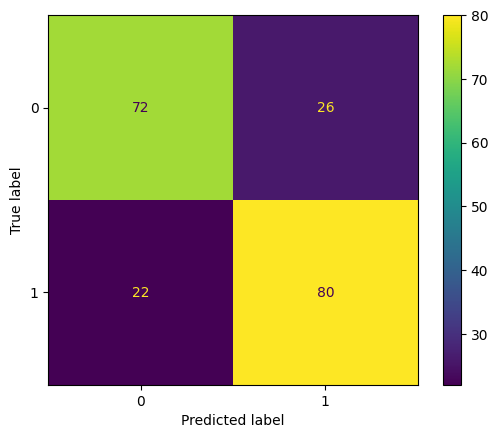

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()    

In [17]:
feature_importance  = pd.DataFrame({'Feature':model.feature_names_in_,
                                    'Importance':model.feature_importances_})
feature_importance.sort_values(['Importance'], ascending=False, inplace=True)
feature_importance

,Feature,Importance
93,tranformer_feats_88,0.024016
21,tranformer_feats_16,0.022022
19,tranformer_feats_14,0.022006
38,tranformer_feats_33,0.018986
40,tranformer_feats_35,0.018588
...,...,...
42,tranformer_feats_37,0.000000
105,tranformer_feats_100,0.000000
22,tranformer_feats_17,0.000000
109,tranformer_feats_104,0.000000
